In [15]:
# TOMA LOS KMLS NUEVO Y LOS AGREGA A SHP DE RECORRIDOS

In [1]:
import os
import re
import pandas as pd
import geopandas as gpd
from lxml import etree as ET
from shapely.geometry import LineString

import sys
sys.path.append('..')
from config import API_AMIGOCLOUD_TOKEN_ADM
from config import RUTA_UNIDAD_ONE_DRIVE
from config import RUTA_LOCAL_ONE_DRIVE

from config import RUTA_UNIDAD_ONE_DRIVE
from config import RUTA_LOCAL_ONE_DRIVE
from config import POSTGRES_UTEA

from sqlalchemy import create_engine

def obtener_engine():
    return create_engine(
        f"postgresql+psycopg2://{POSTGRES_UTEA['USER']}:{POSTGRES_UTEA['PASSWORD']}@{POSTGRES_UTEA['HOST']}:{POSTGRES_UTEA['PORT']}/{POSTGRES_UTEA['DATABASE']}"
    )

In [2]:
def get_unidad_local():
    try:
        # ruta del archivo que contiene la información necesaria
        with open('../../unidad_local.txt', 'r') as file:
            unidad = file.readline().strip()
            return unidad
    except FileNotFoundError:
        print("El archivo 'unidad_local.txt' no se encuentra en la ruta especificada.")
    return None

def get_ruta_local():
    try:
        with open('../ruta_local.txt', 'r') as file:
            ruta = file.readline().strip()
            return ruta
    except FileNotFoundError:
        print("El archivo 'ruta_local.txt' no se encuentra en la ruta especificada.")
    return None

In [3]:
# RUTA ONEDRIVE
unidad = get_unidad_local()
ruta = get_ruta_local()
ruta_completa = os.path.join(unidad, ruta)
ruta_completa

'G:\\OneDrive - Ingenio Azucarero Guabira S.A\\_DATOS_PYTHON'

In [4]:
# Convertir 'Flight Time' de milisegundos a minutos y segundos (MM:SS)
def convertir_tiempo(ms):
    try:
        ms = int(ms.strip())  # Convertir a entero y eliminar espacios extra
        segundos = ms // 1000  # Convertir milisegundos a segundos
        minutos = segundos // 60
        segundos = segundos % 60
        return f"{minutos}:{segundos:02d}"  # Formato MM:SS (ej. 9:35)
    except (ValueError, AttributeError):
        return None  # Si hay error, devolver None

def safe_float(value):
    """Convierte un valor a float, si es posible. Si es None o no numérico, devuelve None."""
    try:
        return float(value) if value is not None and value.strip() != "" else None
    except ValueError:
        return None
    
def convertir_kmls_a_shapefile(kml_folder, contenido):
    """
    Convierte varios archivos KML en un solo shapefile con proyección UTM zona 20S.
    Extrae valores de ExtendedData y los agrega como columnas.

    Parámetros:
    kml_folder (str): Carpeta que contiene los archivos KML.
    shapefile_path (str): Ruta donde se guardará el archivo shapefile combinado.
    """
    # Definir namespace de KML
    NAMESPACE = {"kml": "http://www.opengis.net/kml/2.2"}

    # Listas para almacenar los datos
    line_geometries = []
    filenames = []
    fechas = []
    horas = []
    ids = []
    
    aircraft_names = []
    flight_controller_ids = []
    pilot_names = []
    flight_times = []
    mode_selections = []
    heights = []
    route_spacings = []
    task_flight_speeds = []
    task_areas = []
    spray_amounts = []
    
    for filename in contenido:
        if filename.endswith('.kml'):
            kml_path = os.path.join(kml_folder, filename)
        
            try:
                with open(kml_path, 'r', encoding='utf-8') as file:
                    tree = ET.parse(file)
                    root = tree.getroot()
            except Exception as e:
                print(f"❌ Error al leer {filename}: {e}")
                continue
            
            # Extraer fecha, hora e ID del nombre del archivo
            # match = re.search(r'T\d+_(\d{4})(\d{2})(\d{2})(\d{2})(\d{2})(\d{2})_(R\d+)\.kml', filename)
            match = re.search(r'T\d+-\d+_(\d{4})(\d{2})(\d{2})(\d{2})(\d{2})(\d{2})_(R\d+)\.kml', filename)
            if not match:
                print(f"⚠ Advertencia: Nombre de archivo {filename} no coincide con el patrón esperado.")
                continue
            
            date = f"{match.group(1)}-{match.group(2)}-{match.group(3)}"
            time = f"{match.group(4)}:{match.group(5)}:{match.group(6)}"
            record_id = match.group(7)

            # Buscar Placemark en XML
            placemarks = root.findall('.//Placemark')
            if not placemarks:
                placemarks = root.findall('.//kml:Placemark', NAMESPACE)

            if not placemarks:
                print(f"⚠ Advertencia: No se encontraron <Placemark> en {filename}.")
                continue

            for placemark in placemarks:
                # Buscar LineString correctamente
                line_string = placemark.find('.//LineString')
                if line_string is None:
                    line_string = placemark.find('.//kml:LineString', NAMESPACE)
                
                if line_string is not None:
                    # Buscar Coordinates correctamente
                    coordinates = line_string.find('.//coordinates')
                    if coordinates is None:
                        coordinates = line_string.find('.//kml:coordinates', NAMESPACE)

                    if coordinates is not None and coordinates.text.strip():
                        coords = coordinates.text.strip().split()
                        points = [tuple(map(float, coord.split(',')[:2])) for coord in coords]  # Solo lat, lon
                        line_geometries.append(LineString(points))
                        fechas.append(date)
                        horas.append(time)
                        ids.append(record_id)
                        filenames.append(filename)

                        # Extraer datos de ExtendedData correctamente
                        extended_data = placemark.find('.//ExtendedData')
                        if extended_data is None:
                            extended_data = placemark.find('.//kml:ExtendedData', NAMESPACE)
                        
                        data_dict = {}
                        if extended_data is not None:
                            for data in extended_data.findall('.//Data') or extended_data.findall('.//kml:Data', NAMESPACE):
                                if data is None:
                                    continue  # Skip if there's no Data element

                                name = data.get('name')
                                value_element = data.find('.//kml:value', NAMESPACE)
                                if value_element is None:
                                    value_element = data.find('.//value')

                                value = value_element.text.strip() if value_element is not None and value_element.text else None
                                if name:
                                    data_dict[name] = value  # Store only if the name exists
                    
                        # Agregar valores de ExtendedData a las listas
                        aircraft_names.append(data_dict.get("Aircraft Name", None))
                        flight_controller_ids.append(data_dict.get("Flight Controller ID", None))
                        pilot_names.append(data_dict.get("Pilot Name", None))
                        flight_times.append(convertir_tiempo(data_dict.get("Flight Time", "0")))
                        mode_selections.append(data_dict.get("Mode Selection", None))
                        heights.append(data_dict.get("Height", None))
                        route_spacings.append(data_dict.get("Route Spacing", None))
                        
                        speed_ms = data_dict.get("Task Flight Speed")  # Obtener el valor si existe
                        if speed_ms is None or speed_ms.strip() == "":  # Manejar valores vacíos o None
                            speed_kmh = None
                        else:
                            speed_kmh = float(speed_ms) * 3.6 if speed_ms.replace('.', '', 1).isdigit() else None  # Convertir a km/h
                        task_flight_speeds.append(speed_kmh)
                        
                        task_areas.append(data_dict.get("Task Area", None))
                        spray_amounts.append(data_dict.get("Spray amount", None))

    if not line_geometries:
        print("❌ No se encontraron geometrías válidas en los archivos KML.")
        return

    # Crear un GeoDataFrame con todas las columnas
    gdf = gpd.GeoDataFrame({
        'filename': filenames,
        'fecha': fechas,
        'hora': horas,
        'id': ids,
        'aircraft_name': aircraft_names,
        'flight_controller_id': flight_controller_ids,
        'pilot_name': pilot_names,
        'flight_time': flight_times,
        'mode_selection': mode_selections,
        'height': heights,
        'route_spacing': route_spacings,
        'task_flight_speed': task_flight_speeds,
        'task_area': task_areas,
        'spray_amount': spray_amounts,
        'geometry': line_geometries
    }, crs='EPSG:4326')

    # Transformar a UTM zona 20S (EPSG:32720)
    gdf_utm = gdf.to_crs(epsg=32720)

    gdf_utm['spray_amount'] = gdf_utm['spray_amount'].astype(float) / 1000
    gdf_utm['height'] = gdf_utm['height'].astype(float)
    gdf_utm['route_spacing'] = gdf_utm['route_spacing'].astype(float)
    gdf_utm['task_area'] = gdf_utm['task_area'].astype(float)
    
    gdf_utm.rename(columns={
    'filename': 'file',
    'aircraft_name': 'drone',
    'flight_controller_id': 'ctrl_id',
    'pilot_name': 'pilot',
    'flight_time': 'fl_time',
    'mode_selection': 'mode',
    'height': 'height',
    'route_spacing': 'spacing',
    'task_flight_speed': 'fl_speed',
    'task_area': 'area',
    'spray_amount': 'spray' }, inplace=True)
    
    # Guardar como shapefile
    # gdf_utm.to_file(shapefile_path, driver='ESRI Shapefile')
    # print(f"✅ Archivo shapefile guardado en: {shapefile_path}")
    return gdf_utm

<Axes: >

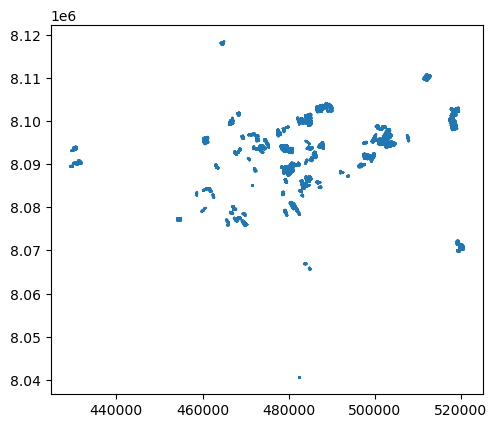

In [5]:
gdf_recorridos = gpd.read_postgis(
    "SELECT * FROM drones_pulverizacion.recorridos_dron_pulv", 
    obtener_engine(), 
    geom_col='geom'  # columna con la geometría
)

gdf_recorridos.plot()

In [6]:
path_kml = unidad + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Pulverizacion\2025\KML_RECORRIDOS'
contenido = os.listdir(path_kml)
len(contenido)

2428

In [7]:
# Filtrar la lista 'contenido' para excluir elementos que están en la columna 'nombre' del GeoDataFrame
contenido_filtrado = [item for item in contenido if item not in gdf_recorridos['file'].values]
len(contenido_filtrado)

222

In [8]:
gdf_nuevos_recorridos = convertir_kmls_a_shapefile(path_kml, contenido_filtrado)

In [9]:
gdf_nuevos_recorridos['idd'] = 0

In [10]:
gdf_nuevos_recorridos = gdf_nuevos_recorridos.rename_geometry('geom')

In [11]:
gdf_nuevos_recorridos.to_postgis(
    name="recorridos_dron_pulv",
    schema="drones_pulverizacion",
    con=obtener_engine(),
    if_exists="append",   # usa "replace" si quieres sobrescribir todo
    index=False
)